In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
%matplotlib inline

In [3]:
### Define input risk parameters

"""
The following data defines your expectation of server failure by server age. e.g. the first line below indicates
that you expect a master server to fail in the first 30 days with a probability if 0.001 or 0.1%.
"""
master_server_life_parameters = [
    (0, 30, 0.001),
    (31, 60, 0.001),
    (61, 90, 0.001),
    (91, 120, 0.005),
    (121, 150, 0.005),
    (151, 180, 0.005),
    (181, 210, 0.005),
    (211, 240, 0.005),
    (241, 270, 0.005),
    (271, 300, 0.005),
    (301, 330, 0.01),
    (331, 360, 0.01),
    (361, 10000, 0.02)
]

segment_server_life_parameters = [
    (0, 30, 0.001),
    (31, 60, 0.005),
    (61, 90, 0.01),
    (91, 120, 0.01),
    (121, 150, 0.01),
    (151, 180, 0.01),
    (181, 210, 0.02),
    (211, 240, 0.02),
    (241, 270, 0.02),
    (271, 300, 0.02),
    (301, 330, 0.02),
    (331, 360, 0.02),
    (361, 10000, 0.05)
]

In [4]:
## Validate and set up

DEBUG = False

class GPEnv(object):
    
    def __init__(self, no_servers, mirror_group):
        self.servers = []
        self.no_servers = no_servers
        self.mirror_group = mirror_group
        print("GPEnv")
        print("    Number of Servers = %d" % no_servers)
        print("    Mirror Group Size = %d" % mirror_group)

        self.valid = True
        if (no_servers % 2 != 0):
            self.valid = False
            print("Number of Servers must be even!")
        elif ((no_servers - 2) % mirror_group != 0):
            self.valid = False
            print("Invalid mirror group configuration !!!")

                
        if (self.valid):
            self.servers = range(0,no_servers)
            self.mdw = 0
            self.smdw = 1
    
        self.server_status = {}
        for srv in self.servers:
            self.server_status[srv] = 1

        self.server_life = {}
        for srv in self.servers:
            self.server_life[srv] = 0

    def mirror_group_of_server(self, serverno):
        if (serverno < 2):
            return 0
        elif (serverno >= self.no_servers):
            return -1
        else:
            return 1 + (serverno - 2) / self.mirror_group

    def check_server_groups(self):
        for srv in self.servers:
            print "%d \t- %d" % (srv, self.mirror_group_of_server(srv))
    
    def prob_of_failure(self, serverno):
        life = self.server_life[serverno]
        if (serverno < 2):
            lookup = master_server_life_parameters
        else:
            lookup = segment_server_life_parameters
        for (st, en, prob) in lookup:
            if (life >= st and life <= en):
                return prob

    def new_day_server(self, serverno):
        life = self.server_life[serverno] + 1
        self.server_life[serverno] = life
        p = self.prob_of_failure(serverno)
        failed = random.uniform(0,1) <= p
        if (failed):
            self.server_status[serverno] = 0
        else:
            self.server_status[serverno] = 1
        return failed

    def new_day(self):
        fail_count = 0
        failed_servers = []
        for srv in self.servers:
            server_failed = self.new_day_server(srv)
            if (server_failed):
                failed_servers.append(srv)
        if (len(failed_servers) > 0):
            failures_by_group = {}
            for srv in failed_servers:
                mg = self.mirror_group_of_server(srv)
                existing = failures_by_group.get(mg)
                if existing:
                    failures_by_group[mg] = existing + 1
                else:
                    failures_by_group[mg] = 1
            for (mg, cnt) in failures_by_group.iteritems():
                if (cnt >= 2):
                    fail_count += cnt / 2
        if (fail_count > 0 and DEBUG):
            print(self.server_status)
        for srv in failed_servers:
            self.server_life[srv] = 0
            self.server_status[srv] = 1
        return fail_count

    def run_scenario(self, days):
        days_failed = 0
        for i in range(days):
            fail_count = self.new_day()
            if (fail_count > 0):
                days_failed += 1
        return days_failed

    def run_simulation(self, cnt, days):
        print("Running simulation.....")
        if not self.valid:
            return
        self.fail_counts = [0] * cnt
        for i in range(cnt):
            self.fail_counts[i] = self.run_scenario(days)
        print("complete.")
        return self.fail_counts

    ## Show simulation results
    def show_sim_results(self):
        data = self.fail_counts
        if not data:
            return
        print("Simulation results for %d servers" % self.no_servers)
        print("=================================")
        print("")
        pcts = [100.0 * d / 2000 for d in data]
        data = np.array(data)
        pcts = np.array(pcts)
        print("Chance of failure in percentage")
        print("Min = %0.2f" % pcts.min())
        print("Avg = %0.2f" % pcts.mean())
        print("Max = %0.2f" % pcts.max())
        print('')
        print("Number of failures in 2000 days")
        print("Min = %0.2f" % data.min())
        print("Avg = %0.2f" % data.mean())
        print("Max = %0.2f" % data.max())
        plt.hist(data)
        plt.title("Histogram")
        plt.xlabel("Number of failures in 2000 days")
        plt.ylabel("Frequency")
        plt.show()


In [5]:
## Run the simulations
no_servers_arr = [6, 10, 18, 34, 102] ### Number of servers including master and standby master server
mirror_group = 4  ### Number of segment servers in each mirror group

envs = []
for no_servers in no_servers_arr:
    env = GPEnv(no_servers, mirror_group)
    data = env.run_simulation(1000, 2000)
    envs.append(env)


GPEnv
    Number of Servers = 6
    Mirror Group Size = 4
Running simulation.....
complete.
GPEnv
    Number of Servers = 10
    Mirror Group Size = 4
Running simulation.....
complete.
GPEnv
    Number of Servers = 18
    Mirror Group Size = 4
Running simulation.....
complete.
GPEnv
    Number of Servers = 34
    Mirror Group Size = 4
Running simulation.....
complete.
GPEnv
    Number of Servers = 102
    Mirror Group Size = 4
Running simulation.....
complete.


Simulation results for 6 servers

Chance of failure in percentage
Min = 0.00
Avg = 0.04
Max = 0.25

Number of failures in 2000 days
Min = 0.00
Avg = 0.75
Max = 5.00


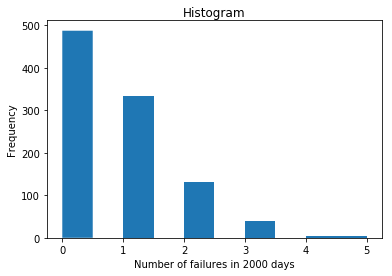

Simulation results for 10 servers

Chance of failure in percentage
Min = 0.00
Avg = 0.07
Max = 0.30

Number of failures in 2000 days
Min = 0.00
Avg = 1.47
Max = 6.00


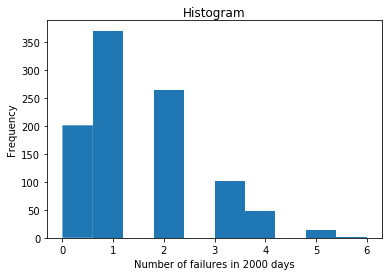

Simulation results for 18 servers

Chance of failure in percentage
Min = 0.00
Avg = 0.15
Max = 0.55

Number of failures in 2000 days
Min = 0.00
Avg = 2.96
Max = 11.00


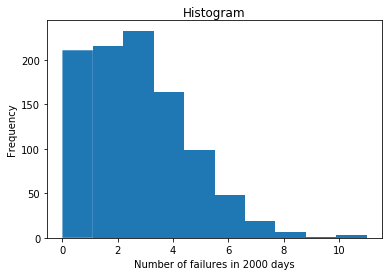

Simulation results for 34 servers

Chance of failure in percentage
Min = 0.00
Avg = 0.29
Max = 0.80

Number of failures in 2000 days
Min = 0.00
Avg = 5.78
Max = 16.00


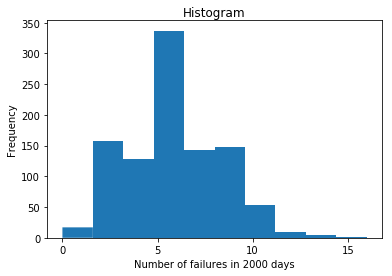

Simulation results for 102 servers

Chance of failure in percentage
Min = 0.25
Avg = 0.91
Max = 1.60

Number of failures in 2000 days
Min = 5.00
Avg = 18.24
Max = 32.00


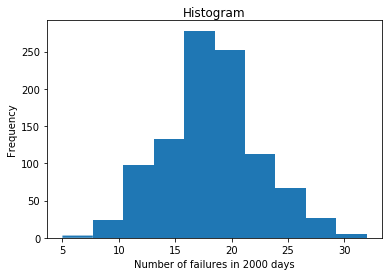

In [6]:
for env in envs:
    env.show_sim_results()
